# Lid-Driven Cavity Problem


### Import Libraries

In [1]:
# Import torch libraries
import torch 
import torch.autograd as autograd # helps in to find gradient (automatic gradient)
from torch import Tensor          # helps to convert the matrix to torch
import torch.nn as nn             # Neural network
import torch.optim as optim       # Optimization

# Libraries for ploting
import matplotlib.pyplot as plt
import scipy.io


import numpy as np  # Numpy 
import math         # Math
import time         # time

# library for generating residual points
from pyDOE import lhs

# libraries for saving datafiles
from numpy import asarray
from numpy import savetxt

### Set seed values for random number generation

In [2]:
# Random number 
torch.set_default_dtype(torch.float)
torch.manual_seed(987)
np.random.seed(987)

### Check for Device GPU

In [3]:
torch.cuda.empty_cache() # Empty the cache memory
device=torch.cuda.get_device_name()  # Save the device name of gpu
print("- Original device name:- ", device)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
print("- Now device name is:- ", device)

- Original device name:-  NVIDIA GeForce RTX 3060 Laptop GPU
- Now device name is:-  cuda


### Generating the coordinates

In [4]:
data_x=np.linspace(0,1,200)    # Generate data x (position) from 0 to 1 (200 equidistance points)
data_y=np.linspace(0,1,200)    # Generate data t (time) from 0 to 8s (100 equitime interval)

# Generate meshgrid for x and t coordinates
X,Y=np.meshgrid(data_x,data_y)

# Flatten the grid structure to a matrix of size [ 200*100 X 2 ]
X_u_test=np.hstack((X.flatten()[:,None],Y.flatten()[:,None]))

# Convert the X_u_test data tensor (for calculation in PyTorch)
X_u_test_tensor=torch.from_numpy(X_u_test).float().to(device)


- Setting up the upper and lower limit from the data, dor feature scaling

In [5]:
lb=X_u_test[0]  # Lower limit
ub=X_u_test[-1] # Upper limit

print(lb,ub)

[0. 0.] [1. 1.]


### Boundary Condition

In [6]:
#   |--------|
#   |        |
#1  |        | 2
#   |________|

In [7]:
# Boundary condition for velocity

#1
boundary_condition1=np.hstack((X[:,0][:,None],Y[:,0][:,None]))
#print(boundary_condition1)
boundary_condition1_u=np.zeros((len(boundary_condition1),1), order="F")
boundary_condition1_v=np.zeros((len(boundary_condition1),1),order="F")
boundary_condition1_p=np.zeros((len(boundary_condition1),1),order="F")

boundary_condition1_uvp=np.hstack([boundary_condition1_u,boundary_condition1_v,boundary_condition1_p])
#print(boundary_condition1_uvp)

#2
boundary_condition2=np.hstack((X[:,-1][:,None],Y[:,-1][:,None]))
#print(boundary_condition2)
boundary_condition2_u=np.zeros((len(boundary_condition2),1), order="F")
boundary_condition2_v=np.zeros((len(boundary_condition2),1), order="F")
boundary_condition2_p=np.zeros((len(boundary_condition2),1), order="F")

boundary_condition2_uvp=np.hstack([boundary_condition2_u,boundary_condition2_v,boundary_condition2_p])
#print(boundary_condition2_uvp)
                                  #3
boundary_condition3=np.hstack((X[0,:][:,None],Y[0,:][:,None]))
#print(boundary_condition3)
boundary_condition3_u=np.zeros((len(boundary_condition3),1),order="F")
boundary_condition3_v=np.zeros((len(boundary_condition3),1),order="F")
boundary_condition3_p=np.zeros((len(boundary_condition3),1),order="F")

boundary_condition3_uvp=np.hstack([boundary_condition3_u,boundary_condition3_v,boundary_condition3_p])

#4
boundary_condition4=np.hstack((X[-1,:][:,None],Y[-1,:][:,None]))
#print(boundary_condition4)
boundary_condition4_u=np.ones((len(boundary_condition4),1),order="F")
boundary_condition4_v=np.zeros((len(boundary_condition4),1),order="F")
boundary_condition4_p=np.zeros((len(boundary_condition4),1),order="F")
boundary_condition4_uvp=np.hstack([boundary_condition4_u,boundary_condition4_v,boundary_condition4_p])
#print(boundary_condition4_uvp)

In [8]:
all_x_train=np.vstack([boundary_condition1,boundary_condition2,boundary_condition3,boundary_condition4])
print(all_x_train.shape)
all_u_train=np.vstack([boundary_condition1_uvp,boundary_condition2_uvp,boundary_condition3_uvp,boundary_condition4_uvp])
print(all_u_train.shape)


(800, 2)
(800, 3)


- N_u $\rightarrow$ Number of points selected from boundary conditions
- N-f $\rightarrow$ Number of points rondomly generated inside the domain, (lhs is used to generate points).

In [9]:
X_u_train=all_x_train
u_train=all_u_train

In [10]:
N_f=2000
X_f_train=lb+(ub-lb)*lhs(2,N_f) #latin hypercube sampling
# random number of N_f points are generated in 2D

savetxt('X_f_train',X_f_train,delimiter=',')

X_f_train=np.vstack((X_f_train, X_u_train))

print(X_f_train.shape)
print(type(X_f_train))

(2800, 2)
<class 'numpy.ndarray'>


### Plotting the residual and training points

(2800, 2)
(800, 2)


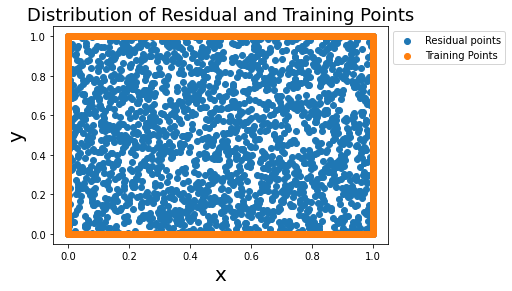

In [11]:
plt.scatter(X_f_train[:,0],X_f_train[:,1],label='Residual points')
plt.scatter(X_u_train[:,0],X_u_train[:,1],label='Training Points')

print(X_f_train.shape)
print(X_u_train.shape)

savetxt('X_u_train',X_u_train,delimiter=',')

plt.xlabel("x",size=20)
plt.ylabel('y',size=20)
plt.legend(bbox_to_anchor=(1,1))
plt.title("Distribution of Residual and Training Points", size=18)

plt.show()

### Convert the data into tensor

In [12]:
X_f_train=torch.from_numpy(X_f_train).float().to(device)
X_u_train=torch.from_numpy(X_u_train).float().to(device)
u_train=torch.from_numpy(u_train).float().to(device)
f_hat=torch.zeros(X_f_train.shape[0],1).to(device)


In [13]:
#print(u_train)

### PINN Class

In [14]:
class PINN(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
        
        self.activation=nn.Tanh()
        
        self.loss_function=nn.MSELoss(reduction='mean')
        self.linears=nn.ModuleList([nn.Linear(layers[i],layers[i+1])for i in range(len(layers)-1)])
        self.iter=0
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data,gain=5/3)
            nn.init.zeros_(self.linears[i].bias.data)
            
    def forward(self,x):
        if torch.is_tensor(x)!=True:
            x=torch.from_numpy(x)
            
        u_b=torch.from_numpy(ub).float().to(device)
        l_b=torch.from_numpy(lb).float().to(device)
        
#         print("ub:",u_b)
#         print("lb",l_b)
#         print("x:",x.shape)
        x=(x-l_b)/(u_b-l_b)
        a=x.float()

        u_lin=torch.cat((a[:,[0]],a[:,[1]]),1)
        v_lin=torch.cat((a[:,[0]],a[:,[1]]),1)
        p_lin=torch.cat((a[:,[0]],a[:,[1]]),1)
        
        
        for i in range(len(layers)-2):
            z1=self.linears[i](u_lin)
            z2=self.linears[i](v_lin)
            z3=self.linears[i](p_lin)
            
            u_lin=self.activation(z1)
            v_lin=self.activation(z2)
            p_lin=self.activation(z3)
            
        u_lin=self.linears[-1](u_lin)
        v_lin=self.linears[-1](v_lin)
        p_lin=self.linears[-1](p_lin)
        
        # predict a=[u,v,p]
        a=torch.cat((u_lin,v_lin,p_lin),1)
        
        return a
    
    def loss_BC(self,x,y):
        
        # BC1
        x1=x[0:200,:]
        y1=y[0:200,:]
#       print("x1:",x1.shape)
        g1=x1.clone()
        g1.requires_grad=True
#         print("g1",g1.shape)
        uvp1=self.forward(g1)
        
        u1=uvp1[:,[0]]
        v1=uvp1[:,[4]]
        p1=uvp1[:,[8]]
        
        p1_xy=autograd.grad(p1,g1,torch.ones([x1.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        p1_x=p1_xy[:,[0]]
        
        # BC2
        x2=x[200:400,:]
        y2=y[200:400,:]
        
        g2=x2.clone()
        g2.requires_grad=True
        
        uvp2=self.forward(g2)
        
        u2=uvp2[:,[0]]
        v2=uvp2[:,[4]]
        p2=uvp2[:,[8]]
        
        p2_xy=autograd.grad(p2,g2,torch.ones([x2.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        p2_x=p2_xy[:,[0]]
        
        # BC3
        x3=x[400:600,:]
        y3=y[400:600,:]
        
        g3=x3.clone()
        g3.requires_grad=True
        
        uvp3=self.forward(g3)
        
        u3=uvp3[:,[0]]
        v3=uvp3[:,[4]]
        p3=uvp3[:,[8]]
        
        p3_xy=autograd.grad(p3,g3,torch.ones([x3.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        p3_y=p3_xy[:,[1]]
        
        # BC4
        x4=x[600:800,:]
        y4=y[600:800,:]

        g4=x4.clone()
        g4.requires_grad=True
        
        uvp4=self.forward(g4)
        
        u4=uvp4[:,[0]]
        v4=uvp4[:,[4]]
        p4=uvp4[:,[8]]
        
        p4_xy=autograd.grad(p4,g4,torch.ones([x4.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        p4_y=p4_xy[:,[1]]
        
        ## Boundary conditions
        #BC1
        loss_bc1_u=self.loss_function(u1,y1[:,[0]])
        loss_bc1_v=self.loss_function(v1,y1[:,[1]])
        loss_bc1_p=self.loss_function(p1_x,y1[:,[2]])
        
        loss_bc1=loss_bc1_u+loss_bc1_v+loss_bc1_p
        
        #BC2
        loss_bc2_u=self.loss_function(u2,y2[:,[0]])
        loss_bc2_v=self.loss_function(v2,y2[:,[1]])
        loss_bc2_p=self.loss_function(p2_x,y2[:,[2]])
        
        loss_bc2=loss_bc2_u+loss_bc2_v+loss_bc2_p
        
        #BC3
        loss_bc3_u=self.loss_function(u3,y3[:,[0]])
        loss_bc3_v=self.loss_function(v3,y3[:,[1]])
        loss_bc3_p=self.loss_function(p3_y,y3[:,[2]])
        
        loss_bc3=loss_bc3_u+loss_bc3_v+loss_bc3_p
        
        #BC4
        loss_bc4_u=self.loss_function(u4,y4[:,[0]])
        loss_bc4_v=self.loss_function(v4,y4[:,[1]])
        loss_bc4_p=self.loss_function(p4_y,y4[:,[2]])
        
        loss_bc4=loss_bc4_u+loss_bc4_v+loss_bc4_p
        
        return loss_bc1+loss_bc2+loss_bc3+loss_bc4
        
    def PDE(self,xy_to_train_f):
        mu=0.01
        
        # Re=100
        # Re=500, 1000, 2000, 3000
        
        g=xy_to_train_f.clone()
        g.requires_grad=True
        
        uvp=self.forward(g)
        
        # Seperate the values
        u=uvp[:,[0]]
        v=uvp[:,[1]]
        p=uvp[:,[2]]
        
        # Calculate the gradient of u, v, and p with respect to x, y.
        
        u_xy=autograd.grad(u,g,torch.ones([xy_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        u_x=u_xy[:,[0]]
        u_y=u_xy[:,[1]]
        
        u_xxyy=autograd.grad(u_xy,g,torch.ones(xy_to_train_f.shape).to(device),create_graph=True)[0]
        u_xx=u_xxyy[:,[0]]
        u_yy=u_xxyy[:,[1]]
        
        v_xy=autograd.grad(v,g,torch.ones([xy_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        v_x=v_xy[:,[0]]
        v_y=v_xy[:,[1]]
        
        v_xxyy=autograd.grad(v_xy,g,torch.ones(xy_to_train_f.shape).to(device),create_graph=True)[0]
        v_xx=v_xxyy[:,[0]]
        v_yy=v_xxyy[:,[1]]
        
        p_xy=autograd.grad(p,g,torch.ones([xy_to_train_f.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        p_x=p_xy[:,[0]]
        p_y=p_xy[:,[1]]
        
        #
        # Differential equations
        f11=u_x+v_y
        f1=mu*(u_xx+u_yy)-p_x-u*u_x-v*u_y
        f2=mu*(v_xx+v_yy)-p_y-u*v_x-v*v_y
        f3=p_x
        f4=p_y
        #
        loss_f11=self.loss_function(f11,f_hat)
        loss_f1=self.loss_function(f1,f_hat)
        loss_f2=self.loss_function(f2,f_hat)
        loss_f3=self.loss_function(f3,f_hat)
        loss_f4=self.loss_function(f4,f_hat)
        
        
        loss_assumptions = loss_f11 + loss_f1 + loss_f2 + loss_f3 + loss_f4
        
#         file1=open('loss_assumptions.txt','a')
#         file1.write(str(loss_assumptions.item())+'\n')
#         file1.close()
        
        return loss_f1+loss_f2+loss_f11+loss_f3
    
    def loss(self,x,y,xy_to_train_f):
        
        loss1=self.loss_BC(x,y)
        
        loss2=self.PDE(xy_to_train_f)
        
        Total_loss=abs(loss1)+abs(loss2)
        
        #1
#         file1=open('loss_BC.txt','a')
#         file1.write(str(loss1.item())+'\n')
#         file1.close()
#         #2
#         file1=open('lossPDE.txt','a')
#         file1.write(str(loss2.item())+'\n')
#         file1.close()
#         #3
#         file1=open('Total_loss.txt','a')
#         file1.write(str(Total_loss.item())+'\n')
#         file1.close()
        
        return Total_loss
    
    def closure(self):
        
        optimizer.zero_grad()
        
        loss=self.loss(X_u_train,u_train,X_f_train)
        
        loss.backward()
        
        self.iter+=1
        
        if self.iter%100==0:
            print(loss)
        
        return loss
    
    def Test(self,xy_test):
        
        Pred_Result=self.forward(xy_test)
        
        Pred_Result=Pred_Result.detach().cpu().numpy()
        
        U_Pred=Pred_Result[:,[0]]
        V_Pred=Pred_Result[:,[4]]
        P_Pred=Pred_Result[:,[8]]
        
        return [U_Pred,V_Pred,P_Pred]
        

In [15]:
layers=[2,100,100,3]

# 500*10, 500*20
# 1000*4, 100*8
# 1000*10, 1000*12

C=PINN(layers)
C.to(device)

params=list(C.parameters())

# Number of iterations

optimizer=torch.optim.LBFGS(C.parameters(),lr=0.1,max_iter=50000,
                           tolerance_grad=1e-10,tolerance_change=1e-15,
                           history_size=1000,line_search_fn="strong_wolfe")

start_time=time.time()
optimizer.step(C.closure)
Training_time=time.time()-start_time

print("Training Time:",Training_time)

# Error-> 10^-6 

tensor(0.1919, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1106, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0813, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0673, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0659, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0650, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0645, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0643, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0641, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0638, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0633, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0630, device='cuda:0', grad_fn=<AddBack

In [16]:
[U_Pred1,V_Pred1,P_Pred1]=C.Test(X_u_test_tensor)

In [17]:
X_u_test_tensor=X_u_test_tensor.detach().cpu().numpy()

In [19]:
print(U_Pred1.shape)

print(X_u_test_tensor[99::200])

savetxt('X_u_test_tensor0_5',X_u_test_tensor[99::200],delimiter=',')
savetxt('U_Pred0_5',U_Pred1[99::200],delimiter=',')
savetxt('V_Pred0_5',V_Pred1[99::200],delimiter=',')
savetxt('P_Pred0_5',P_Pred1[99::200],delimiter=',')

(40000, 1)
[[0.49748743 0.        ]
 [0.49748743 0.00502513]
 [0.49748743 0.01005025]
 [0.49748743 0.01507538]
 [0.49748743 0.0201005 ]
 [0.49748743 0.02512563]
 [0.49748743 0.03015075]
 [0.49748743 0.03517588]
 [0.49748743 0.040201  ]
 [0.49748743 0.04522613]
 [0.49748743 0.05025126]
 [0.49748743 0.05527638]
 [0.49748743 0.06030151]
 [0.49748743 0.06532663]
 [0.49748743 0.07035176]
 [0.49748743 0.07537688]
 [0.49748743 0.08040201]
 [0.49748743 0.08542714]
 [0.49748743 0.09045226]
 [0.49748743 0.09547739]
 [0.49748743 0.10050251]
 [0.49748743 0.10552764]
 [0.49748743 0.11055277]
 [0.49748743 0.11557789]
 [0.49748743 0.12060302]
 [0.49748743 0.12562814]
 [0.49748743 0.13065326]
 [0.49748743 0.1356784 ]
 [0.49748743 0.14070351]
 [0.49748743 0.14572865]
 [0.49748743 0.15075377]
 [0.49748743 0.1557789 ]
 [0.49748743 0.16080402]
 [0.49748743 0.16582915]
 [0.49748743 0.17085427]
 [0.49748743 0.1758794 ]
 [0.49748743 0.18090452]
 [0.49748743 0.18592964]
 [0.49748743 0.19095477]
 [0.49748743 0

In [20]:
savetxt('U_Pred1',U_Pred1,delimiter=',')
savetxt('X_u_test_tensor',X_u_test_tensor,delimiter=',')
#savetxt('u6',u6,delimiter=',')

In [21]:
savetxt('P_Pred1',P_Pred1,delimiter=',')

In [22]:
savetxt('V_Pred1',V_Pred1,delimiter=',')

In [120]:
1/40

0.025